In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle &> /dev/null
!cp kaggle.json ~/.kaggle/ &> /dev/null
!chmod 600 ~/.kaggle/kaggle.json &> /dev/null
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification &> /dev/null
!unzip ham1000-segmentation-and-classification.zip &> /dev/null

Saving kaggle.json to kaggle (1).json


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

In [3]:
csv_path = "/content/GroundTruth.csv"
data_table = pd.read_csv(csv_path)
data_table.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# creating a normal encoding for all the columns for straitfying the dataset
# could also use labelencoder class in scikitlearn
enc_label = pd.DataFrame()
labels = data_table.drop(["image"], axis=1)
enc_label['label'] = labels.idxmax(axis=1)
enc_label['label'] = enc_label['label'].str.replace('MEL', '1')
enc_label['label'] = enc_label['label'].str.replace('NV', '2')
enc_label['label'] = enc_label['label'].str.replace('BCC', '3')
enc_label['label'] = enc_label['label'].str.replace('AKIEC', '4')
enc_label['label'] = enc_label['label'].str.replace('BKL', '5')
enc_label['label'] = enc_label['label'].str.replace('DF', '6')
enc_label['label'] = enc_label['label'].str.replace('VASC', '7')
enc_label.head()

,label
0,2
1,2
2,2
3,2
4,1


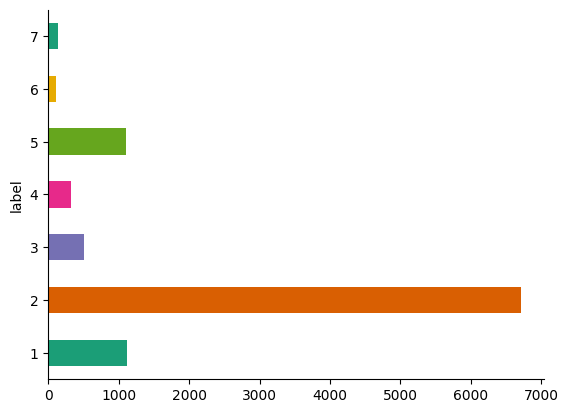

In [5]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
enc_label.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [6]:
data_table = pd.concat([data_table, enc_label], axis=1)
data_table.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [7]:
# x_train, x_tv, y_train, y_tv  = train_test_split(data_table['image'],data_table['label'], train_size=0.7, stratify=data_table['label'])
# x_val, x_test, y_val, y_test =train_test_split(x_tv, y_tv, train_size=0.5, stratify=y_tv['label'])

train_df, x_df = train_test_split(data_table, train_size=0.7, stratify=data_table['label'])
val_df, test_df = train_test_split(x_df, train_size=0.5, stratify=x_df['label'])

print(f"train:{train_df['label'].value_counts()}")
print(f"val:{val_df['label'].value_counts()}")
print(f"test:{test_df['label'].value_counts()}")

train:label
2    4693
1     779
5     769
3     360
4     229
7      99
6      81
Name: count, dtype: int64
val:label
2    1006
1     167
5     165
3      77
4      49
7      21
6      17
Name: count, dtype: int64
test:label
2    1006
1     167
5     165
3      77
4      49
7      22
6      17
Name: count, dtype: int64


In [8]:
# train_df.drop(['label'], axis=1, inplace=True)
# val_df.drop(['label'], axis=1, inplace=True)
# test_df.drop(['label'], axis=1, inplace=True)

In [9]:
x_train = train_df['image']
x_val = val_df['image']
x_test = test_df['image']
y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

In [10]:
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
labels = ['1','2','3','4','5','6','7']

os.makedirs("/content/train", exist_ok=True)
os.makedirs("/content/val", exist_ok=True)
os.makedirs("/content/test", exist_ok=True)

for label in labels:
  train_folders = os.path.join("/content/train", label)
  os.makedirs(train_folders, exist_ok=True)
  val_folders = os.path.join("/content/val", label)
  os.makedirs(val_folders, exist_ok=True)
  test_folders = os.path.join("/content/test", label)
  os.makedirs(test_folders, exist_ok=True)

In [11]:
for img_fname, label in zip(x_train, y_train):
  shutil.copy2("/content/images/"+img_fname+".jpg", "/content/train/"+label)

for img_fname, label in zip(x_val, y_val):
  shutil.copy2("/content/images/"+img_fname+".jpg", "/content/val/"+label)
for img_fname, label in zip(x_test, y_test):
  shutil.copy2("/content/images/"+img_fname+".jpg", "/content/test/"+label)


In [12]:
# images preprocessing
test_valid_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((224, 224)),
     transforms.ColorJitter(brightness=0.1, contrast=0.4, saturation=0.1, hue=0.1)
     ])

train_preprocessing = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.Resize((224, 224)),
     transforms.ColorJitter(brightness=0.1, contrast=0.4, saturation=0.1, hue=0.1),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomRotation(degrees=30),
     ])


In [13]:
train_dataset = ImageFolder("/content/train", transform=train_preprocessing)
val_dataset = ImageFolder("/content/val", transform=test_valid_transform)
test_dataset = ImageFolder("/content/test", transform=test_valid_transform)

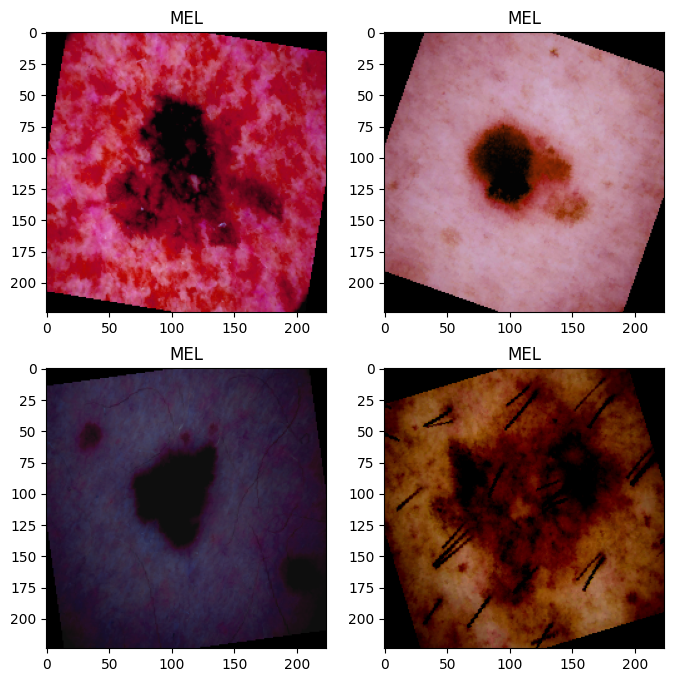

In [19]:
# few pics to display preprocessing

plt.figure(figsize=(8, 8))
for i in range(4):
  img, label = train_dataset[i]
  plt.subplot(2, 2, i+1)
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[label])

In [14]:
# train_ds = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_ds = DataLoader(val_dataset, batch_size=32, shuffle=True)